In [148]:
import json
import csv
import pandas as pd
from pandas import DataFrame, Series
import dateutil.parser
from dateutil.tz import gettz
import datetime
import pytz
from functools import reduce
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline


In [149]:
#mood reporter DF

responsesDF = pd.read_csv("../reporter/responses.tsv", sep='\t', header=0)

timeValues = responsesDF.unix_time.values

def roundUnixTime(timestamp):
    timestamp = timestamp - (timestamp % 3600)
    return timestamp

def convertTime(timestamp):
    timestamp = time.gmtime(timestamp)
    return timestamp


activity_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.activity.values)])))))

for activity_name in activity_names:
    responsesDF[activity_name.replace(" ", "_") + "_activity"] = responsesDF.activity.apply(lambda x: activity_name in x.lower())

location_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.location.values)])))))

def split_locations(locations):
    return list(map(lambda x: x.lower().strip(), locations.split(",")))

for location_name in location_names:
    responsesDF[location_name.replace(" ", "_") + "_location"] = responsesDF.location.apply(lambda x: location_name in split_locations(x))

# responsesDF.time = responsesDF.unix_time.apply(roundUnixTime)
# responsesDF.time = responsesDF.time.apply(convertTime)
responsesDF.time = responsesDF.unix_time

del responsesDF['moodNotes']
del responsesDF['trigger']
del responsesDF['activity']
del responsesDF['location']
del responsesDF['unix_time']


outputsDF = responsesDF[['time','mood', 'morale', 'stress', 'unique_interactions', 'fatigue', 'compulsions', 'alone']].copy()

def convertUTCToTimestamp(timestamp):
    nanosecondTimestamp = timestamp * 1e9
    timestamp = pd.Timestamp(nanosecondTimestamp, tz='US/Eastern')
    return timestamp

outputsDF.time = outputsDF.time.apply(convertUTCToTimestamp)

In [150]:
tone_names = ['Sadness', 'Analytical', 'Joy', 'Fear', 'Tentative', 'Anger', 'Confident']
#keylogger DF


with open('../keylogger/logs/log_new.json', 'r') as f:
    keyloggerData = json.load(f)

# tzinfos = { "EDT" : gettz("America/New_York") }

def extract_keyloggerData(data):
    keyloggerResults = []
    keystrokeWordCountResults = []

    for d in data:
#         result = [0]*(len(tone_names) + 6)
        keyloggerResult = [0] * (len(tone_names)+1)
        keystrokeWordCountResult = [0] * 6
        
        tones = d['document_tone']['tones']
        for i in range(len(tones)):
            score = tones[i]['score']
            tone_name = tones[i]['tone_name']
            tone_index = tone_names.index(tone_name)
            keyloggerResult[tone_index] = score            

        keyloggerResult[-1] = d['unix_time']

        keyloggerResults.append(tuple(keyloggerResult))
        
        try:
            keystrokeWordCountResult[0] = d['word_count']
            keystrokeWordCountResult[1] = d['uniqueword_ratio']
            keystrokeWordCountResult[2] = d['backspace_count']
            keystrokeWordCountResult[3] = d['avg_dwelltime']
            keystrokeWordCountResult[4] = d['avg_flighttime']
            keystrokeWordCountResult[5] = d['unix_time']
            
            keystrokeWordCountResults.append(tuple(keystrokeWordCountResult))
            
        except:
            continue
            
    return keyloggerResults, keystrokeWordCountResults

both = extract_keyloggerData(keyloggerData)

keyloggerDF = DataFrame(both[0],
                        columns=[tone_name+"_score" for tone_name in tone_names] + ['time'])

keystrokeWordCountDF = DataFrame(both[1],
                        columns=['word_count', 'uniqueword_ratio', 'backspace_count', 'avg_dwelltime', 'avg_flighttime', 'time'])

keyloggerDF.time = keyloggerDF.time.apply(convertUTCToTimestamp)
keyloggerDF.sort_values('time', inplace=True)

keystrokeWordCountDF.time = keystrokeWordCountDF.time.apply(convertUTCToTimestamp)
keystrokeWordCountDF.sort_values('time', inplace=True)

In [151]:
#affectiva DF


with open('../getAPIdata/merged_file.json', 'r') as f:
    affectivaData = json.load(f)

for x in range(0, len(affectivaData)):
#         affectivaData[x]['time'] = time.gmtime(affectivaData[x]['time']/ 1e3)
        affectivaData[x]['time'] = affectivaData[x]['time']/ 1e3
        affectivaData[x]['emoji'] = len(affectivaData[x]['emoji'])

#     affectivaData[x]['time'] = utc_to_local(datetime.datetime.fromtimestamp((affectivaData[x]['time']/ 1e3)))


affectivaDF = DataFrame(affectivaData)

del affectivaDF['emotions']
del affectivaDF['max_attention']
del affectivaDF['min_attention']
del affectivaDF['max_engagement']
del affectivaDF['min_engagement']
del affectivaDF['max_valence']
del affectivaDF['min_valence']
affectivaDF.time = affectivaDF.time.apply(convertUTCToTimestamp)
affectivaDF.sort_values('time', inplace=True)

In [152]:
#productivity DF
from dateutil import parser
import calendar

with open('../getAPIdata/productivity.json', 'r') as f:
    productivityFile = json.load(f)

productivityData = productivityFile['rows']

final_productivityData = [];
UTC = pytz.timezone('UTC')

for x in range(0, len(productivityData)):
#     if(productivityData[x][0] > '2018-04-01T00:00:00'):
    date = parser.parse(productivityData[x][0])
    dateutc = str(date.astimezone(UTC))
    dateutc2 = dateutc[:19] + "UTC"
    newtime = time.strptime(dateutc2, "%Y-%m-%d %H:%M:%S%Z")
    finalTime = calendar.timegm(newtime)
    prod_score = productivityData[x][4]
    final_productivityData.append((finalTime, prod_score))

productivityDF = DataFrame(final_productivityData, columns=['time', 'productivity_score'])
productivityDF.time = productivityDF.time.apply(convertUTCToTimestamp)

productivityDF.sort_values('time', inplace=True)

In [153]:
# google fit

def convertTimeToStruct(timestamp):
    timestamp = time.gmtime(timestamp)
    return timestamp


with open('../google_fit/dataset.json', 'r') as f:
    fitData = json.load(f)
    

stepCountCompressed = []

def extract_fitData(fitData):
    current_timestamp = int(fitData[0]['endTimeNanos']) / 1e9
    current_hour = convertTimeToStruct(int(fitData[0]['endTimeNanos']) / 1e9)
    stepCount = 0

    for d in fitData:
        dHour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
        if (dHour.tm_year == current_hour.tm_year and dHour.tm_mon == current_hour.tm_mon and dHour.tm_mday == current_hour.tm_mday and dHour.tm_hour == current_hour.tm_hour):
            stepCount += int(d['value'][0]['intVal'])
        else:
            holder = [0] * 2
            holder[0] = current_timestamp
#             holder[1] = current_hour
            holder[1] = stepCount
            
            stepCountCompressed.append(tuple(holder))
            stepCount = 0

            current_hour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
            current_timestamp = int(d['endTimeNanos']) / 1e9

            stepCount += int(d['value'][0]['intVal'])

extract_fitData(fitData['point'])


stepCountDF = DataFrame(stepCountCompressed, columns = ['time', 'stepCount'])
# exerciseDF.time = exerciseDF.time.apply(convertTimeToUnix)

stepCountDF.time = stepCountDF.time.apply(convertUTCToTimestamp)
stepCountDF.sort_values('time', inplace=True)

In [154]:
#tabcounter

with open('../getAPIdata/chromeactivity.json', 'r') as f:
    tabCounterData = json.load(f)

newTabData = []

for key in tabCounterData:
    timestamp = int(key) / 1e3

#     timestamp = time.gmtime(int(key) / 1e3)
#     time = utc_to_local(datetime.datetime.fromtimestamp((int(key)/ 1e3)))
    current_tabCount = tabCounterData[key]['current_tabCount']
    current_windowCount = tabCounterData[key]['current_windowCount']
    tabs_activated = tabCounterData[key]['tabs_activated']
    tabs_created = tabCounterData[key]['tabs_created']
    windows_created = tabCounterData[key]['windows_created']

    newTabData.append([timestamp, current_tabCount, current_windowCount,tabs_activated,tabs_created,windows_created])

tabColumns = ['time', 'current_tabCount', 'current_windowCount','tabs_activated','tabs_created','windows_created']
tabCounterDF = DataFrame(newTabData, columns=tabColumns)
# tabCounterDF.time = tabCounterDF.time.apply(roundTime)

tabCounterDF.time = tabCounterDF.time.apply(convertUTCToTimestamp)

tabCounterDF.sort_values('time', inplace=True)


In [155]:
heartRateDF = pd.read_csv("../webcam-pulse-detector-no_openmdao/heartRate.csv", sep=',', header=0)

heartRateDF.time = heartRateDF.time.apply(convertUTCToTimestamp)
heartRateDF.sort_values('time', inplace=True)
heartRateDF = heartRateDF.reset_index(drop=True)
heartRateDF

,time,heart_rate
0,2017-04-10 15:13:25.332000-04:00,76.000000
1,2017-04-11 15:16:23.648999936-04:00,76.000000
2,2017-04-13 18:47:34.732000-04:00,71.000000
3,2017-04-15 23:28:07.452000256-04:00,61.000000
4,2018-05-18 16:49:27.304000-04:00,74.000000
5,2018-05-18 16:50:11.352000256-04:00,78.000000
6,2018-05-18 21:03:53.100000-04:00,71.000000
7,2018-05-18 21:05:05.046000128-04:00,78.000000
8,2018-05-18 21:05:44.860999936-04:00,72.000000
9,2018-05-19 18:39:47.284000-04:00,76.000000


In [156]:
def hourOnly(timestamp):
    timestamp = timestamp.hour
#     if (timestamp < 6):
#         timestamp = timestamp + 24
    return timestamp


hourColumn = pd.to_datetime(outputsDF.time, unit='s')
hourDF = DataFrame(hourColumn)
hourDF.sort_values('time', inplace=True)
hourDF['hour'] = hourDF.time.apply(hourOnly)


In [157]:
outputsDF['rolling_mean_mood'] = outputsDF['mood'].rolling(25).mean()
outputsDF.dropna(inplace=True)
outputsDF.reset_index(inplace=True)
del outputsDF['index']

In [158]:
outputsDF['mood_mean_difference'] = outputsDF['rolling_mean_mood'] - outputsDF['mood']
outputsDF

,time,mood,morale,stress,unique_interactions,fatigue,compulsions,alone,rolling_mean_mood,mood_mean_difference
0,2018-04-12 12:39:29.819958016-04:00,2.0,3.0,4,0,2.0,False,True,3.40,1.40
1,2018-04-12 13:40:07.405005056-04:00,2.0,2.0,4,0,2.0,False,True,3.32,1.32
2,2018-04-12 14:42:51.922734848-04:00,2.0,3.0,4,0,2.0,False,True,3.24,1.24
3,2018-04-12 16:47:51.900183808-04:00,2.0,2.0,4,0,3.0,False,True,3.20,1.20
4,2018-04-12 17:57:38.743968-04:00,3.0,3.0,2,1,3.0,False,False,3.20,0.20
5,2018-04-12 21:00:10.756322048-04:00,3.0,3.0,2,1,4.0,False,False,3.20,0.20
6,2018-04-13 09:07:26.361488128-04:00,5.0,4.0,1,2,1.0,False,False,3.28,-1.72
7,2018-04-13 14:26:12.496000-04:00,4.0,4.0,2,5,3.0,True,True,3.28,-0.72
8,2018-04-13 15:27:43.578693888-04:00,4.0,4.0,2,0,3.0,False,True,3.28,-0.72
9,2018-04-13 16:29:00.230368768-04:00,3.0,3.0,2,1,3.0,True,True,3.28,0.28


In [180]:
mergedDF1 = pd.merge_asof(keyloggerDF, keystrokeWordCountDF, on='time', tolerance=pd.Timedelta('1 hours')).dropna()
mergedDF1.reset_index(inplace=True)
del mergedDF1['index']

mergedDF2 = pd.merge_asof(affectivaDF, mergedDF1, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF2.reset_index(inplace=True)
del mergedDF2['index']

mergedDF3 = pd.merge_asof(mergedDF2, stepCountDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).fillna(0)
mergedDF3.reset_index(inplace=True)
del mergedDF3['index']

mergedDF4 = pd.merge_asof(mergedDF3, tabCounterDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF4.reset_index(inplace=True)
del mergedDF4['index']

mergedDF5 = pd.merge_asof(mergedDF4, productivityDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF5.reset_index(inplace=True)
del mergedDF5['index']

# mergedDF6 = pd.merge_asof(outputsDF, hourDF, on='time', direction='nearest', tolerance=pd.Timedelta('1 hours')).dropna()
# mergedDF6.reset_index(inplace=True)
# del mergedDF6['index']

hourColumn3 = pd.to_datetime(outputsDF.time, unit='s')
hourDF3 = DataFrame(hourColumn3)
hourDF3.sort_values('time', inplace=True)
outputsDF['hour'] = hourDF3.time.apply(hourOnly)

finalMergedDF = pd.merge_asof(outputsDF, mergedDF5, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
finalMergedDF.reset_index(inplace=True)
del finalMergedDF['index']

finalMergedDF

,time,mood,morale,stress,unique_interactions,fatigue,compulsions,alone,rolling_mean_mood,mood_mean_difference,...,backspace_count,avg_dwelltime,avg_flighttime,stepCount,current_tabCount,current_windowCount,tabs_activated,tabs_created,windows_created,productivity_score
0,2018-05-30 23:43:50.779942912-04:00,3.5,3.5,0,0,3.0,True,True,3.30,-0.20,...,4.0,0.087153,0.171138,0.0,26.0,2.0,19.0,4.0,0.0,51.70
1,2018-05-31 00:54:24.027759104-04:00,3.0,2.0,0,0,3.5,True,True,3.24,0.24,...,4.0,0.087153,0.171138,0.0,26.0,2.0,19.0,4.0,0.0,51.70
2,2018-06-02 15:37:29.052293120-04:00,2.5,2.0,3.5,0,2.5,True,True,3.18,0.68,...,55.0,0.100966,0.208556,1121.0,25.0,2.0,62.0,7.0,0.0,20.13
3,2018-06-02 16:40:40.727516928-04:00,2.5,2.0,2,3,1.5,False,True,3.16,0.66,...,55.0,0.100966,0.208556,1121.0,25.0,2.0,62.0,7.0,0.0,20.13
4,2018-06-02 19:08:28.065821184-04:00,3.0,2.5,1,1,1.0,False,True,3.10,0.10,...,15.0,0.101219,0.311904,10.0,25.0,2.0,4.0,0.0,0.0,34.25
5,2018-06-02 20:19:14.888844032-04:00,3.0,3.0,0,0,1.5,False,True,3.06,0.06,...,15.0,0.101219,0.311904,10.0,23.0,2.0,0.0,0.0,0.0,33.50
6,2018-06-02 21:25:25.471260160-04:00,3.0,2.5,0,0,1.5,True,True,3.06,0.06,...,49.0,0.089719,0.281055,0.0,23.0,2.0,16.0,4.0,0.0,22.86
7,2018-06-02 22:25:59.244112896-04:00,2.5,2.0,0,0,2.0,True,True,3.06,0.56,...,49.0,0.089719,0.281055,0.0,23.0,2.0,0.0,0.0,0.0,42.77
8,2018-06-02 23:26:34.387373056-04:00,3.0,3.0,0,0,2.5,False,True,3.08,0.08,...,49.0,0.089719,0.281055,0.0,23.0,2.0,0.0,0.0,0.0,42.77
9,2018-06-03 11:41:26.987131136-04:00,3.0,3.0,0,2,2.0,False,True,3.06,0.06,...,12.0,0.114056,0.237108,19.0,24.0,2.0,10.0,3.0,0.0,20.83


In [192]:
justmoodDF = DataFrame() 
justmoodDF['fatigue'] = outputsDF['fatigue'].copy()
justmoodDF['time'] = outputsDF['time'].copy()


hourColumn2 = pd.to_datetime(justmoodDF.time, unit='s')
hourDF2 = DataFrame(hourColumn2)
hourDF2.sort_values('time', inplace=True)
justmoodDF['hour'] = hourDF2.time.apply(hourOnly)

noOutputsDF = pd.merge_asof(mergedDF5, justmoodDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()

from sklearn.externals import joblib
joblib.dump(noOutputsDF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF_noOutputs_fatigue.pkl') 

# justmoraleDF = DataFrame() 
# justmoraleDF['morale'] = outputsDF['morale'].copy()
# justmoraleDF['time'] = outputsDF['time'].copy()
# moraleHour = pd.merge_asof(justmoraleDF, hourDF, on='time', direction='nearest', tolerance=pd.Timedelta('1 hour')).dropna()
# mergedDF_onlyMorale = pd.merge_asof(mergedDF5, moraleHour, on='time', direction='backward', tolerance=pd.Timedelta('2 hours')).dropna()
# mergedDF_onlyMorale

# from sklearn.externals import joblib
# joblib.dump(mergedDF_onlyMorale, '/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF_moraleOutput.pkl') 

['/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF_noOutputs_fatigue.pkl']

In [181]:
from sklearn.externals import joblib
finalMergedDF.replace(False, 0, inplace=True)
finalMergedDF.replace(True, 1, inplace=True)
finalMergedDF['alone'].replace("True", 1, inplace=True)
finalMergedDF['alone'].replace("False", 0, inplace=True)
finalMergedDF
joblib.dump(finalMergedDF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF_forNN5.pkl') 


['/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF_forNN5.pkl']

In [70]:
from sklearn.svm import SVR

from sklearn import ensemble

y_mood_mean_difference = finalMergedDF["mood_mean_difference"]
y_morale = finalMergedDF["morale"]
y_mood = finalMergedDF["mood"]
y_stress = finalMergedDF["stress"]

finalFeaturesList = list(finalMergedDF.columns.drop('time').drop("mood").drop("morale").drop("stress").drop("unique_interactions").drop("fatigue").drop("compulsions").drop("alone").drop("rolling_mean_mood").drop("mood_mean_difference"))
X = finalMergedDF[finalFeaturesList]


# morale
X_train, X_test, y_morale_train, y_morale_test = train_test_split(
    X, y_morale, test_size=0.20, shuffle=False)

morale_RF = ensemble.RandomForestRegressor(bootstrap=True, max_features='sqrt', max_depth=120, min_samples_leaf=9, min_samples_split=6, n_estimators=450)
morale_RF = morale_RF.fit(X_train, y_morale_train)


# mood-mean-difference
# {'C': 1.5, 'epsilon': 0.3, 'gamma': 1e-07, 'kernel': 'rbf'}

X_train, X_test, y_mood_mean_difference_train, y_mood_mean_difference_test = train_test_split(
    X, y_mood_mean_difference, test_size=0.20, shuffle=False)

# mood_mean_diff_SVR = SVR(C=32, epsilon=0.42, gamma=1e-07, kernel='rbf')
# mood_mean_diff_SVR = mood_mean_diff_SVR.fit(X_train, y_mood_mean_difference_train)

mood_mean_diff_RF = ensemble.RandomForestRegressor(bootstrap=True, max_features='sqrt', max_depth=120, min_samples_leaf=9, min_samples_split=6, n_estimators=450)
mood_mean_diff_RF = mood_mean_diff_RF.fit(X_train, y_mood_mean_difference_train)

# print(morale_LM.score(X_test, y_morale_test))
# print(stress_RF.score(X_test, y_stress_test))
# print(social_LM.score(X_test, y_social_test))
# print(fatigue_LM.score(X_test, y_fatigue_test))
# print(compulsions_LM.score(X_test, y_compulsions_test))
# print(alone_LM.score(X_test, y_alone_test))
print(morale_RF.score(X_test, y_morale_test))
# print(mood_mean_diff_SVR.score(X_test, y_mood_mean_difference_test))
print(mood_mean_diff_RF.score(X_test, y_mood_mean_difference_test))




0.124704972332
0.0607970230656


In [187]:
from sklearn.metrics import r2_score
# print(morale_RF.score(X_train, y_morale_train))
# print(mood_mean_diff_RF.score(X_train, y_mood_mean_difference_train))
y_pred_morale = morale_RF.predict(X_test)
print(r2_score(y_morale_test, y_pred_morale))

y_pred = mood_mean_diff_RF.predict(X_test)
print(r2_score(y_mood_mean_difference_test, y_pred))


0.124704972332
0.0607970230656


In [61]:
from sklearn.externals import joblib

joblib.dump(mood_mean_diff_RF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/mood_mean_diff_RF.pkl') 


['/Users/jxu2/github/thesis_explorations/life_support/predictor/mood_mean_diff_RF.pkl']

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


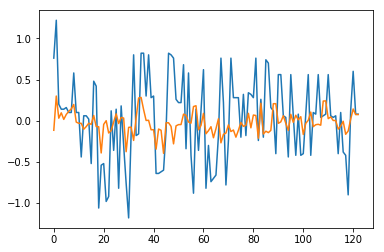

In [189]:
import matplotlib.pyplot as plt 

y_mood_mean_difference_test_new = y_mood_mean_difference_test.reset_index()
del y_mood_mean_difference_test_new['index']
plt.plot(y_mood_mean_difference_test_new)
plt.plot(y_pred)
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 115, 120, 125, 130],
    'max_features': ['sqrt'],
    'min_samples_leaf': [6, 7, 8, 9],
    'min_samples_split': [4, 5, 6, 7, 8],
    'n_estimators': [450, 500, 450]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = mood_mean_diff_RF, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_mood_mean_difference_train)

In [ ]:
grid_search.best_params_